In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import DATA

Load data from JOINED TABLE by (JOINING-TABLES.ipynb)

In [3]:
customer = pd.read_csv('OLIST-DATA/olist_customers_dataset.csv')
orders = pd.read_csv('OLIST-DATA/olist_orders_dataset.csv')
geolocation_replace = pd.read_csv('geolocation_mean_replace_geolocation_dataset.csv')
order_items = pd.read_csv('OLIST-DATA/olist_order_items_dataset.csv')

In [4]:
geo = geolocation_replace.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'})

merged = (
    orders
    .merge(customer, on='customer_id', how='left')
    .merge(order_items, on='order_id', how='left')
    .merge(geo, on='customer_zip_code_prefix', how='left')
)


In [5]:
merged.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 161
order_delivered_carrier_date     1968
order_delivered_customer_date    3229
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                     775
product_id                        775
seller_id                         775
shipping_limit_date               775
price                             775
freight_value                     775
geolocation_lat_mean              306
geolocation_lng_mean              306
geolocation_lat_std               508
geolocation_lng_std               508
dtype: int64

In [6]:
merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'geolocation_lat_mean',
       'geolocation_lng_mean', 'geolocation_lat_std', 'geolocation_lng_std'],
      dtype='object')

In [7]:
# parse purchase timestamp and extract year, month, day
merged['order_purchase_datetime'] = pd.to_datetime(merged['order_purchase_timestamp'], errors='coerce')
merged['order_purchase_year'] = merged['order_purchase_datetime'].dt.year
merged['order_purchase_month'] = merged['order_purchase_datetime'].dt.month
merged['order_purchase_day'] = merged['order_purchase_datetime'].dt.day

# quick check
merged[['order_purchase_timestamp','order_purchase_datetime','order_purchase_year','order_purchase_month','order_purchase_day']]

,order_purchase_timestamp,order_purchase_datetime,order_purchase_year,order_purchase_month,order_purchase_day
0,2017-10-02 10:56:33,2017-10-02 10:56:33,2017,10,2
1,2018-07-24 20:41:37,2018-07-24 20:41:37,2018,7,24
2,2018-08-08 08:38:49,2018-08-08 08:38:49,2018,8,8
3,2017-11-18 19:28:06,2017-11-18 19:28:06,2017,11,18
4,2018-02-13 21:18:39,2018-02-13 21:18:39,2018,2,13
...,...,...,...,...,...
113420,2018-02-06 12:58:58,2018-02-06 12:58:58,2018,2,6
113421,2017-08-27 14:46:43,2017-08-27 14:46:43,2017,8,27
113422,2018-01-08 21:28:27,2018-01-08 21:28:27,2018,1,8
113423,2018-01-08 21:28:27,2018-01-08 21:28:27,2018,1,8


In [8]:
orders = (
    merged[['customer_unique_id', 'order_purchase_datetime']]
    .dropna()
    .sort_values(['customer_unique_id', 'order_purchase_datetime'])
)

orders['prev_purchase'] = (
    orders.groupby('customer_unique_id')['order_purchase_datetime']
    .shift(1)
)

orders

,customer_unique_id,order_purchase_datetime,prev_purchase
60152,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,NaT
84207,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,NaT
30148,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,NaT
112316,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,NaT
47364,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,NaT
...,...,...,...
99129,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2017-06-08 21:00:36
23418,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,NaT
50081,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,NaT
110454,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,NaT


In [9]:
orders['days_since_prev'] = (
    orders['order_purchase_datetime'] - orders['prev_purchase']
).dt.total_seconds() / 86400

orders

,customer_unique_id,order_purchase_datetime,prev_purchase,days_since_prev
60152,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,NaT,NaN
84207,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,NaT,NaN
30148,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,NaT,NaN
112316,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,NaT,NaN
47364,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,NaT,NaN
...,...,...,...,...
99129,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08 21:00:36,2017-06-08 21:00:36,0.0
23418,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,NaT,NaN
50081,ffff371b4d645b6ecea244b27531430a,2017-02-07 15:49:16,NaT,NaN
110454,ffff5962728ec6157033ef9805bacc48,2018-05-02 15:17:41,NaT,NaN


In [10]:
intervals = (
    orders
    .dropna(subset=['days_since_prev'])
    .loc[orders['days_since_prev'] > 0, ['days_since_prev']]
    .copy()
)

intervals

,days_since_prev
45288,16.368264
45634,170.724896
58361,267.313484
46837,31.040359
102596,10.582361
...,...
25310,22.718009
90539,3.149132
79602,186.303113
40170,182.033877


In [11]:
intervals

,days_since_prev
45288,16.368264
45634,170.724896
58361,267.313484
46837,31.040359
102596,10.582361
...,...
25310,22.718009
90539,3.149132
79602,186.303113
40170,182.033877


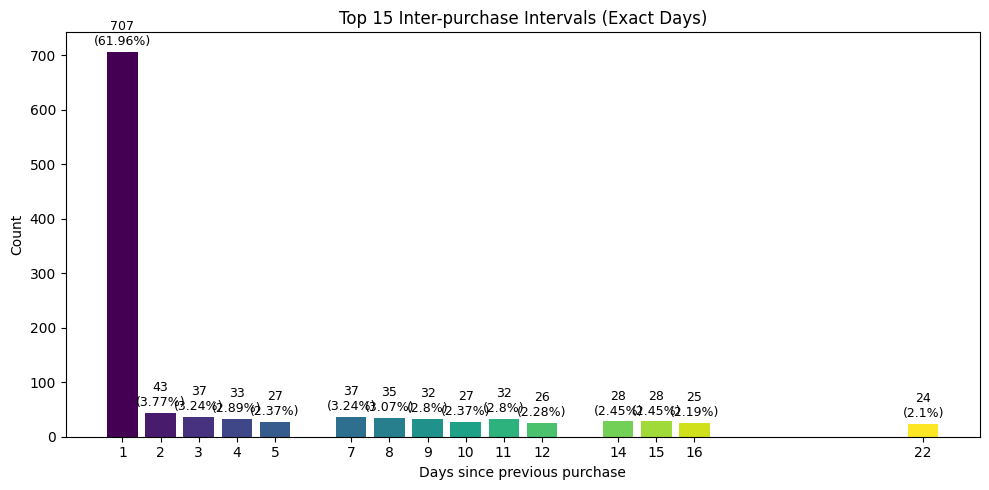

In [12]:
orders = (
    merged[['customer_unique_id', 'order_purchase_datetime']]
    .dropna()
    .sort_values(['customer_unique_id', 'order_purchase_datetime'])
)

orders['prev_purchase'] = (
    orders.groupby('customer_unique_id')['order_purchase_datetime']
    .shift(1)
)

orders['days_since_prev'] = (
    orders['order_purchase_datetime'] - orders['prev_purchase']
).dt.total_seconds() / 86400.0

intervals = orders.loc[
    orders['days_since_prev'].notna() & (orders['days_since_prev'] > 0),
    ['days_since_prev']
].copy()

intervals['days_since_prev'] = np.ceil(intervals['days_since_prev']).astype(int)


TOP_N = 15

dist_counts = intervals['days_since_prev'].value_counts()
top_counts = dist_counts.head(TOP_N).sort_index()   

top_pct = (top_counts / top_counts.sum() * 100).round(2)

x = top_counts.index.values

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(
    x,
    top_counts.values,
    width=0.8,
    color=plt.cm.viridis(np.linspace(0, 1, len(x)))
)

ax.set_xticks(x)
ax.set_xlabel('Days since previous purchase')
ax.set_ylabel('Count')
ax.set_title(f'Top {TOP_N} Inter-purchase Intervals (Exact Days)')

y_offset = top_counts.max() * 0.01
for xi, c, p in zip(x, top_counts.values, top_pct.values):
    ax.text(xi, c + y_offset, f"{c}\n({p}%)", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

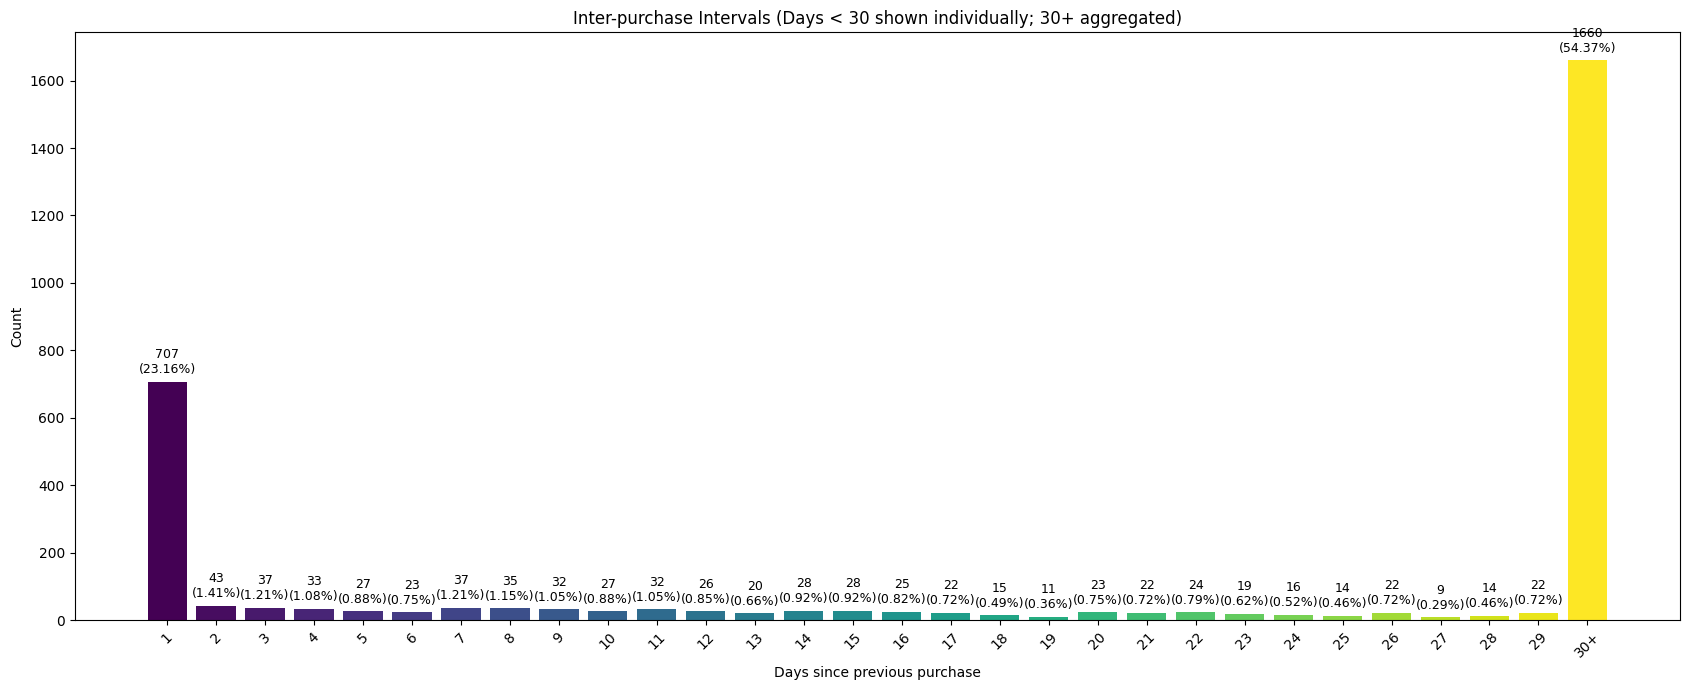

In [ ]:
CUTOFF_DAY = 30

dist_counts = intervals['days_since_prev'].value_counts().sort_index()

exact_counts = dist_counts[dist_counts.index < CUTOFF_DAY]
tail_count = dist_counts[dist_counts.index >= CUTOFF_DAY].sum()

final_counts = exact_counts.copy()
final_counts[f'{CUTOFF_DAY}+'] = tail_count

final_pct = (final_counts / final_counts.sum() * 100).round(2)

x_labels = final_counts.index.astype(str)
x_pos = np.arange(len(x_labels))

fig, ax = plt.subplots(figsize=(17, 7))

ax.bar(
    x_pos,
    final_counts.values,
    color=plt.cm.viridis(np.linspace(0, 1, len(x_pos)))
)

ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, rotation=45)
ax.set_xlabel('Days since previous purchase')
ax.set_ylabel('Count')
ax.set_title(f'Inter-purchase Intervals (Days < {CUTOFF_DAY} shown individually; {CUTOFF_DAY}+ aggregated)')

y_offset = final_counts.max() * 0.01
for i, (c, p) in enumerate(zip(final_counts.values, final_pct.values)):
    ax.text(
        i,
        c + y_offset,
        f"{c}\n({p}%)",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.tight_layout()
plt.show()

# สรุปลูกค้า(ฝั่งออนไลน์ทั่วไป) ไม่สามารถใช้การมองแบบ Churn ได้เพราะเราจะเห็นได้ว่าไม่มีการกลับมาซื้อ (Royalty) มาพอจะทำโมเดลนี้